In [1]:


import pandas as pd

In [2]:
import os
import rasterio
import numpy as np

# Set the directory path containing the .tif files (X_train, y_train, X_test)
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp', '../data/raw/test_satellite']

# Get a list of all files in the directory (X_train, y_train, X_test)
file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

# Sort the file list to ensure consistent order
file_list = [sorted(files) for files in file_list]

# Initialize an empty array to store the image data
X_train, y_train, X_test = [], [], []

# Iterate through the selected files
for X_train_name, y_train_name in zip(file_list[0], file_list[1]):
    # Construct the full path to the file
    X_train_path = os.path.join(directory_paths[0], X_train_name)
    y_train_path = os.path.join(directory_paths[1], y_train_name)

    # Open the raster file using rasterio
    with rasterio.open(X_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_train.append(image_data)

    # Open the raster file using rasterio
    with rasterio.open(y_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        y_train.append(image_data)

for X_test_name in file_list[2]:
    # Construct the full path to the file
    X_test_path = os.path.join(directory_paths[2], X_test_name)

    with rasterio.open(X_test_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_test.append(image_data)

# Convert the list of arrays to a single NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Print the shape of the resulting array
print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)
print("Shape of the X_test array:", X_test.shape)

metadata = pd.read_csv('../data/raw/metadata.csv')

C:\Users\hjdeh\Documents\GitHub\Q2\kelp-forest-exploration\venv\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5635, 7, 350, 350)
Shape of the y_train array: (5635, 1, 350, 350)
Shape of the X_test array: (1426, 7, 350, 350)


In [3]:
bands = ["SWIR", "NIR", "Red", "Green", "Blue", "Cloud Mask", "Digital Elevation Map"]

metadata = metadata.sort_values(by=['in_train', 'filename'], ascending=[False, True])

print(len(metadata))
metadata.head()

12696


tile_id                filename                          md5_hash  \
994   AA498489  AA498489_satellite.tif  59b984f8f7fe343884efed7cfb26d64a   
1873  AA648736  AA648736_satellite.tif  d3c0dc6609867db1157e6190205a1aee   
3899  AA800151  AA800151_satellite.tif  065c3410af64673f2ceed134215d13e3   
650   AA878727  AA878727_satellite.tif  3afb5204237cf4f9fcdf3f9fa33d15c9   
5005  AB160377  AB160377_satellite.tif  581f2bc5ea545409a1f202eeb9e233f5   

      filesize_bytes       type  in_train  
994          1059490  satellite      True  
1873         1186857  satellite      True  
3899         1391679  satellite      True  
650          1216266  satellite      True  
5005         1626251  satellite      True

In [4]:
from matplotlib import pyplot as plt
from rasterio.plot import show
from matplotlib.colors import ListedColormap


def normalize_images(images_array: np.ndarray):
    # Create an empty array to store the normalized image data
    normalized_images_array = np.zeros(images_array.shape)

    # Iterate through each band
    for i in range(images_array.shape[1]):
        # Get the band data
        band = images_array[:, i, :, :]
        # Set NaNs to 0 (Nan = -32768 in the original images)
        # For band 0 to 4, normalize the band data to values between 0 and 1 by dividing by 65535
        if i < 5:
            band[band == -32768] = 0
            normalized_band = band / 65535.0
        # For band 5 do nothing
        elif i == 5:
            normalized_band = band
        # For band 6, do normal normalization
        elif i == 6:
            normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))

        # Store the normalized band data
        normalized_images_array[:, i, :, :] = normalized_band

    return normalized_images_array


def visualize_images(filenames: list, is_train=True):
    # Create a 2x3 grid for image display
    num_rows = len(filenames)
    num_cols = 5

    if is_train:
        X_normed = normalize_images(X_train[filenames, :, :, :])
    else:
        X_normed = normalize_images(X_test[filenames, :, :, :])
    # Normalize the images

    # Create a figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(80, num_rows * 20))

    # Flatten the 2D array of subplots into a 1D array
    axes = axes.flatten()
    c = 0
    cmap_mask = ListedColormap(['black', 'white'])
    # Display each image in a subplot
    for i in range(0, num_rows * num_cols, 5):
        # Display the RGB image
        show(X_normed[c, 2:5, :, :], ax=axes[i])
        axes[i].set_title("RGB Image")

        # Display the SWIR, NIR, Red image
        show(X_normed[c, 0:3, :, :], ax=axes[i + 1])
        axes[i + 1].set_title(f"SWIR, NIR, Red Image and file: {file_list[0][c + 10]}")

        # Display the Cloud mask band (5)

        axes[i + 2].imshow(X_normed[c, 5, :, :], cmap=cmap_mask)
        axes[i + 2].set_title("Cloud Mask")

        # Display the Digital Elevation Map band (6)
        show(X_normed[c, 6, :, :], ax=axes[i + 3])
        axes[i + 3].set_title("Digital Elevation Map")

        # Display the label
        show(X_normed[c, 0:3, :, :], ax=axes[i + 4])
        if is_train:
            axes[i + 4].imshow(y_train[filenames[c]][0], cmap='jet', alpha=0.5 * (y_train[filenames[c]][0] > 0))
        axes[i + 4].set_title("Label")
        # Display the SWIR, NIR, Red image with the label
        c += 1

    # Adjust layout for better spacing
    plt.tight_layout()
    if is_train:
        plt.savefig(f'../plots/images/train/visualize_images{str(filenames)}.png')
    else:
        plt.savefig(f'../plots/images/test/visualize_images{str(filenames)}.png')
    plt.show()


In [5]:
visualize_images([4, 5, 6, 7])

## NaN analysis

In [6]:
# Count the number of -32768 values for each band. These are NaNs, calculate the percentage of NaNs for each band
print("Train")
nan_count = np.sum(X_train == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_train.shape[0] * X_train.shape[2] * X_train.shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")

print("\nTest")
nan_count = np.sum(X_test == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_test.shape[0] * X_test.shape[2] * X_test.shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")

Train
Band SWIR                     : NaN Count = 28213403, NaN Percentage = 4.09%
Band NIR                      : NaN Count = 28216871, NaN Percentage = 4.09%
Band Red                      : NaN Count = 28254528, NaN Percentage = 4.09%
Band Green                    : NaN Count = 28252553, NaN Percentage = 4.09%
Band Blue                     : NaN Count = 28537626, NaN Percentage = 4.13%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.00%
Band Digital Elevation Map    : NaN Count = 26868442, NaN Percentage = 3.89%

Test
Band SWIR                     : NaN Count = 6981719, NaN Percentage = 4.00%
Band NIR                      : NaN Count = 6982737, NaN Percentage = 4.00%
Band Red                      : NaN Count = 6990982, NaN Percentage = 4.00%
Band Green                    : NaN Count = 6988761, NaN Percentage = 4.00%
Band Blue                     : NaN Count = 7045466, NaN Percentage = 4.03%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.

## NaN - Get the images that have the highest percentage of NaNs

In [7]:
# Get the indices of the images with the highest percentage of NaNs

print("Train")
nan_count = np.sum(X_train == -32768, axis=(1, 2, 3))

nan_percentage = nan_count / (X_train.shape[1] * X_train.shape[2] * X_train.shape[3]) * 100

#Sort the indices by the percentage of NaNs
sorted_indices_train = np.argsort(nan_percentage)

# Print the top 5 images with the highest percentage of NaNs
for i in range(5):
    print(
        f"Image {sorted_indices_train[-i - 1]:<5}: NaN Count = {nan_count[sorted_indices_train[-i - 1]]:<6}, NaN Percentage = {nan_percentage[sorted_indices_train[-i - 1]]:.2f}%")

print("\nTest")
nan_count = np.sum(X_test == -32768, axis=(1, 2, 3))

nan_percentage = nan_count / (X_test.shape[1] * X_test.shape[2] * X_test.shape[3]) * 100

#Sort the indices by the percentage of NaNs decendingly
sorted_indices_test = np.argsort(nan_percentage)

# Print the top 5 images with the highest percentage of NaNs
for i in range(5):
    print(
        f"Image {sorted_indices_test[-i - 1]:<5}: NaN Count = {nan_count[sorted_indices_test[-i - 1]]:<6}, NaN Percentage = {nan_percentage[sorted_indices_test[-i - 1]]:.2f}%")
    



Train
Image 4482 : NaN Count = 604870, NaN Percentage = 70.54%
Image 5288 : NaN Count = 593862, NaN Percentage = 69.26%
Image 719  : NaN Count = 565060, NaN Percentage = 65.90%
Image 4487 : NaN Count = 523210, NaN Percentage = 61.02%
Image 3339 : NaN Count = 519636, NaN Percentage = 60.60%

Test
Image 906  : NaN Count = 622920, NaN Percentage = 72.64%
Image 414  : NaN Count = 571490, NaN Percentage = 66.65%
Image 1336 : NaN Count = 556525, NaN Percentage = 64.90%
Image 704  : NaN Count = 544270, NaN Percentage = 63.47%
Image 670  : NaN Count = 542495, NaN Percentage = 63.26%


In [ ]:
# Put the image with the nan COunt and percentage in a dataframe
df_nan_count = pd.DataFrame({'Image': sorted_indices_train[::-1], 'NaN Count': nan_count[sorted_indices_train[::-1]], 'NaN Percentage': nan_percentage[sorted_indices_train[::-1]]})

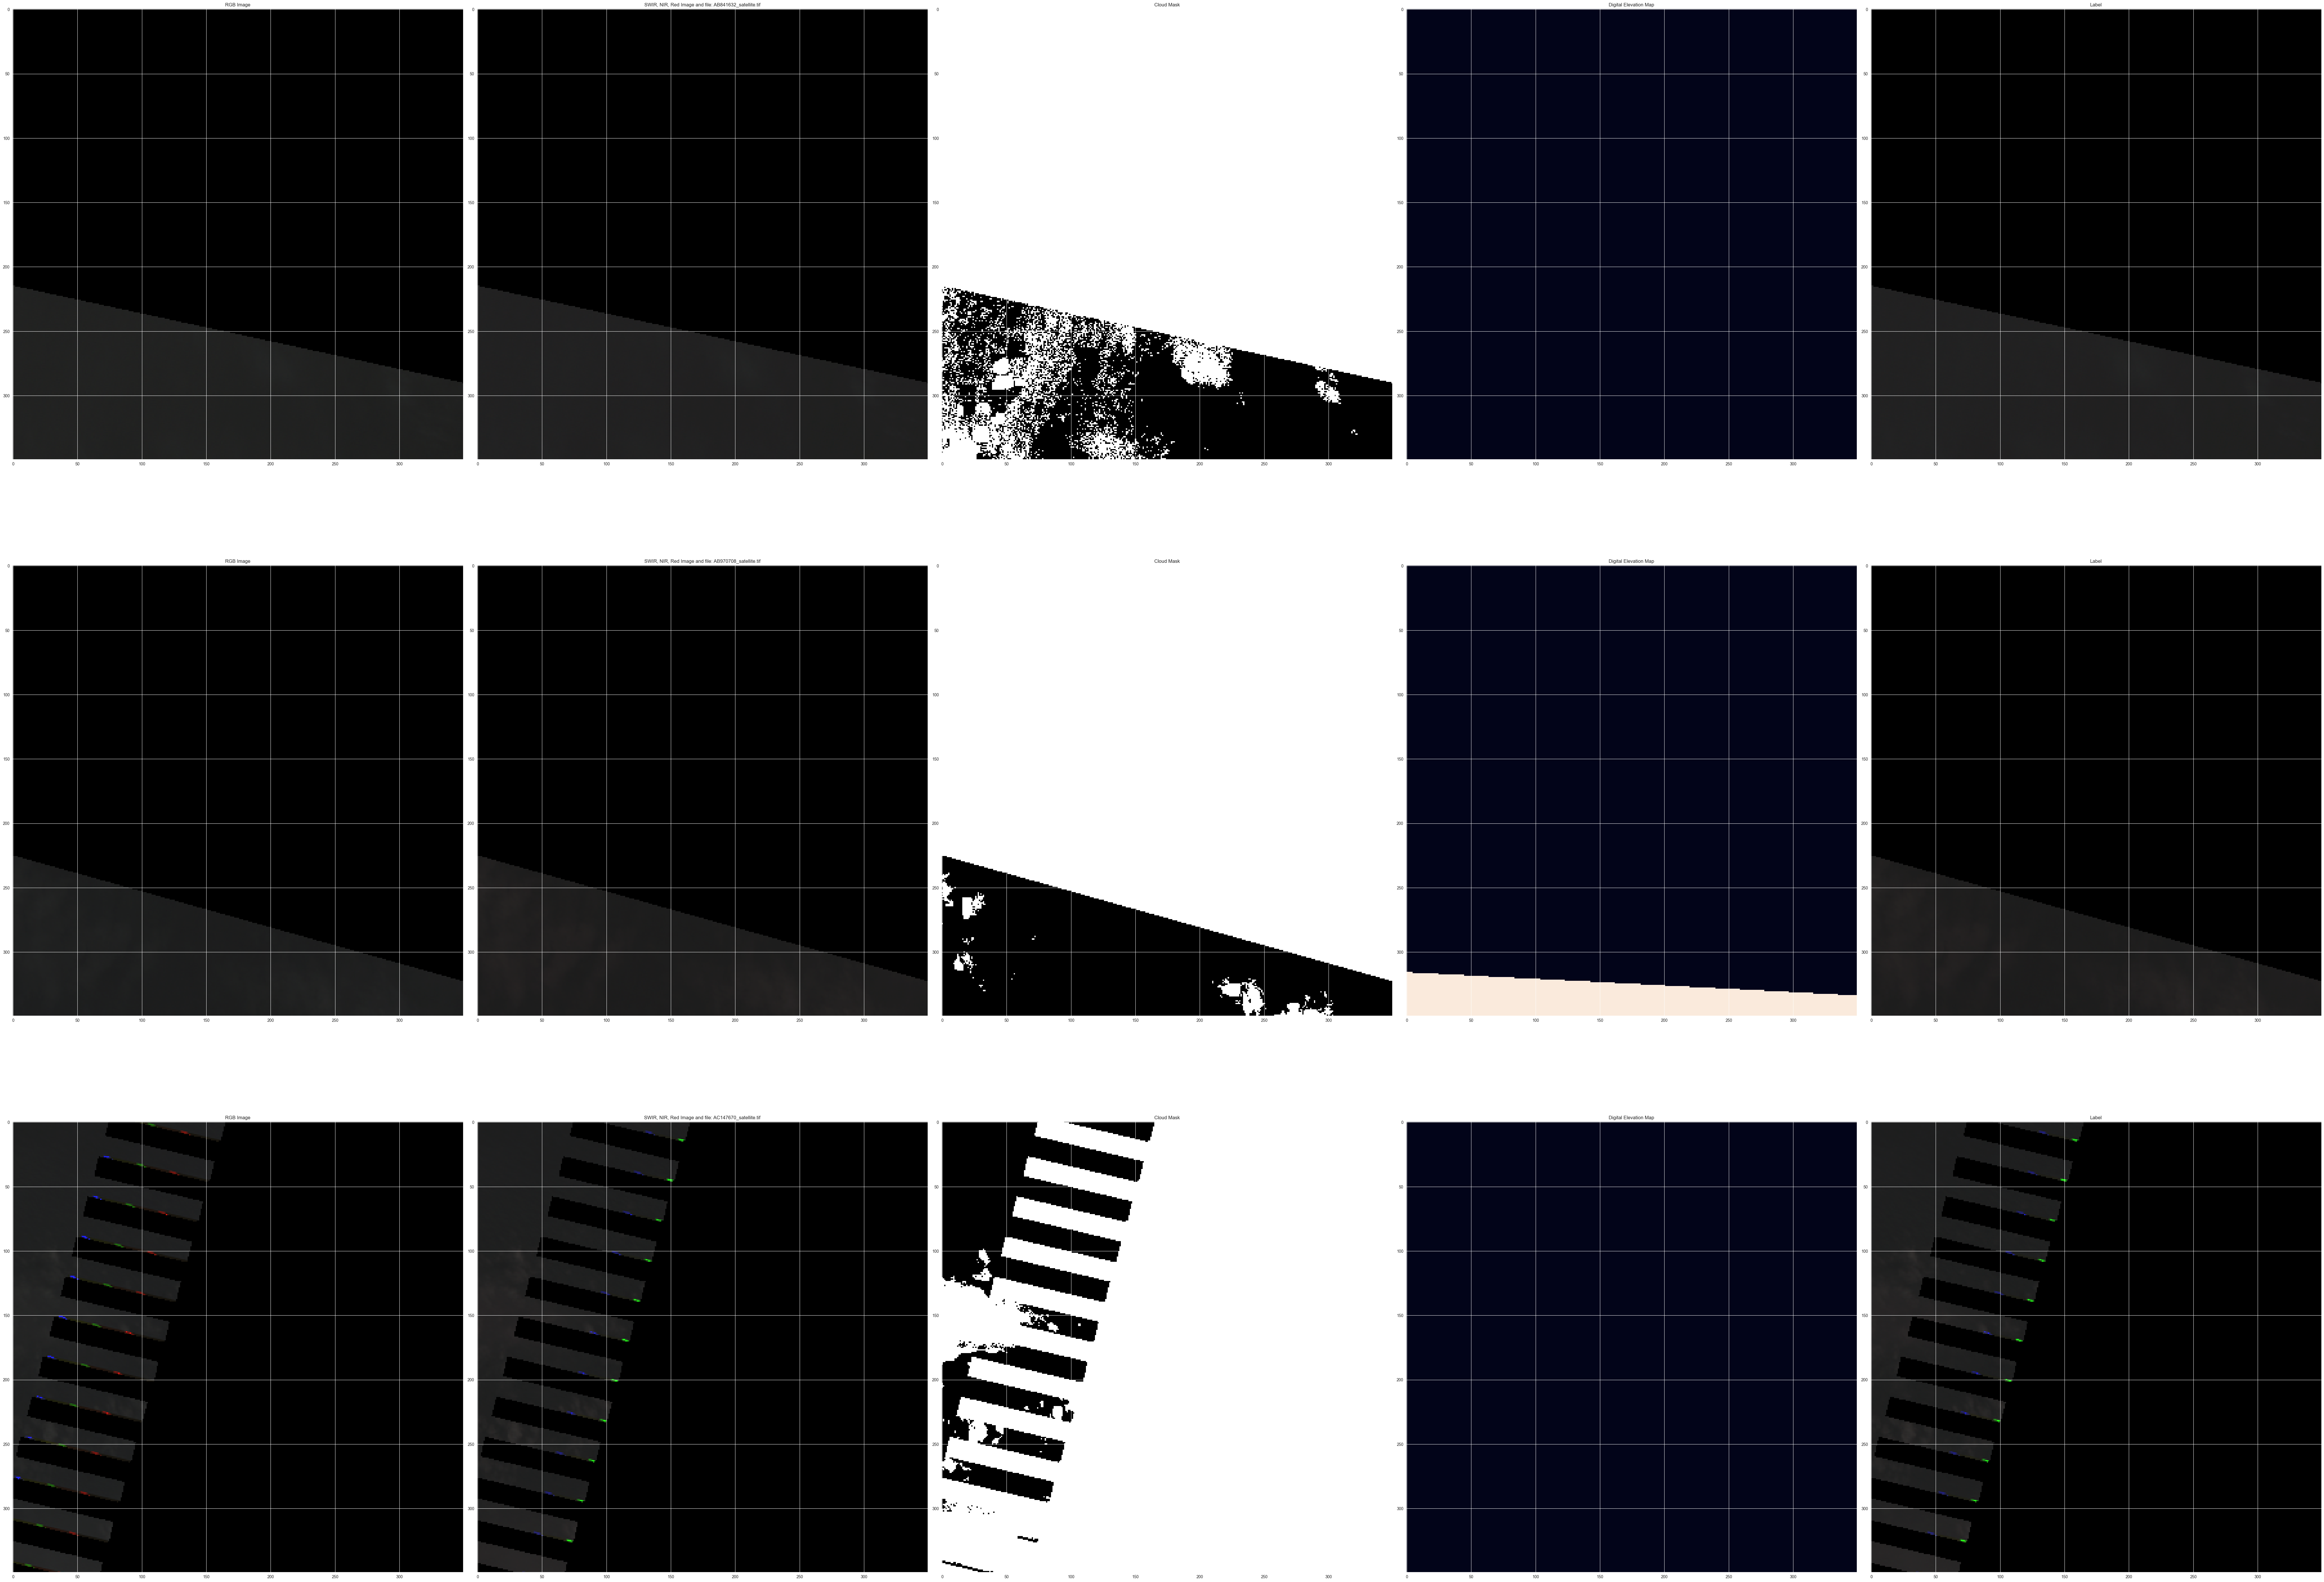

In [8]:
visualize_images(sorted_indices_train[-3:])

In [9]:
visualize_images(sorted_indices_test[-5:], is_train=False)

### Is there kelp in the images with the highest percentage of NaNs?

This is very interesting, lets analyse this by making a kdeplot over all bands to show the distribution of the bands values depending if there is kelp or no kelp


 Lets now try to get all values but apply a subsample and use that in the KDE Plot. THis is the correct way.

In [12]:
bands_kelp_subsample = []
bands_no_kelp_subsample = []

#Plot using seaborn:
for band in range(7):
    print(band)
    # For each band, get the values of the band where kelp is present and where kelp is not present

    # Get the indices where kelp is present
    y_kelp = np.where(y_train.ravel() != 0)
    X_kelp = X_train[:, band, :, :].ravel()[y_kelp]

    # Get the indices where kelp is not present
    y_no_kelp = np.where(y_train.ravel() == 0)
    X_no_kelp = X_train[:, band, :, :].ravel()[y_no_kelp]

    bands_kelp_subsample.append(X_kelp)
    bands_no_kelp_subsample.append(X_no_kelp)


0
1
2
3


MemoryError: Unable to allocate 5.11 GiB for an array with shape (685615166, 1) and data type int64

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(7, 1, figsize=(20, 30))

#Get indices where 

for band in range(7):
    # Subsample 20000 values from kelp
    kelp = np.random.choice(bands_kelp_subsample[band], 50000)

    # If kelp is nan (-32768) set to -10
    kelp[kelp == -32768] = -10

    # Subsample 20000 values from no kelp
    no_kelp = np.random.choice(bands_no_kelp_subsample[band], 50000)

    # If no kelp is nan (-32768) set to -10
    no_kelp[no_kelp == -32768] = -10

    #Plot the kdeplot
    sns.kdeplot(data=[kelp, no_kelp], ax=axes[band], bw_adjust=.2)
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["No Kelp", "Kelp"])

    #Set range of plots from 0-20000
    axes[band].set_xlim(0, 20000)

    if band == 5:
        axes[band].set_xlim(0, 1)

    if band == 6:
        axes[band].set_xlim(-100, 1000)

In [ ]:
fig, axes = plt.subplots(7, 1, figsize=(20, 30))

#Get indices where 

for band in range(7):
    # Subsample 20000 values from kelp
    kelp = np.random.choice(bands_kelp_subsample[band], 50000)

    # If kelp is nan (-32768) set to -10
    kelp[kelp == -32768] = -10
    
    # Subsample 20000 values from no kelp
    no_kelp = np.random.choice(bands_no_kelp_subsample[band], 50000)
    # If no kelp is nan (-32768) set to -10
    no_kelp[no_kelp == -32768] = -10
    #Plot the kdeplot
    sns.histplot(data=[kelp, no_kelp], ax=axes[band])
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["No Kelp", "Kelp"])

    #Set range of plots from 0-20000
    axes[band].set_xlim(0, 20000)

    if band == 5:
        axes[band].set_xlim(0, 1)

    if band == 6:
        axes[band].set_xlim(-100, 1000)